# CZ4041 Group 28 Notebook 1
This Notebook Concludes with a Generated .csv file Indicating allMissing Score of the Test Dataset Passed through the Model and a .h5 file which is the Model itself.

<h2>Importing the Libraries</h2>

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import SVG
from tqdm import tqdm

import keras
import tensorflow as tf
from keras import backend as K
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import Adam, Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import model_to_dot, plot_model

Using TensorFlow backend.


## Setting Up Directory

In [2]:
train_folder = os.path.join('/kaggle/input','/severstal-steel-defect-detection/train_images')
test_folder = os.path.join('/kaggle/input','/severstal-steel-defect-detection/test_images')

train_images_set = set()
test_images_set = set()

count=0
for dirname, _, filenames in os.walk('/kaggle/input/severstal-steel-defect-detection'):
    count=0
    for filename in filenames:
        count+=1
        if dirname == '/kaggle/input/severstal-steel-defect-detection/train_images':
            train_images_set.add(filename)
        if dirname == '/kaggle/input/severstal-steel-defect-detection/test_images':
            test_images_set.add(filename)
#         print(os.path.join(dirname, filename))
    if dirname == '/kaggle/input/severstal-steel-defect-detection/train_images':
        no_train_images = count
        print(dirname)
        print("no_train_images >", count)
    if dirname == '/kaggle/input/severstal-steel-defect-detection/test_images':
        no_test_images = count
        print(dirname)
        print("no_test_images >", count)
    print(dirname)
        
# print(train_images_set)
# Any results you write to the current directory are saved as output.

/kaggle/input/severstal-steel-defect-detection
/kaggle/input/severstal-steel-defect-detection/train_images
no_train_images > 12568
/kaggle/input/severstal-steel-defect-detection/train_images
/kaggle/input/severstal-steel-defect-detection/test_images
no_test_images > 5506
/kaggle/input/severstal-steel-defect-detection/test_images


<h2>Pre-Processing</h2>

In [3]:
train_df = pd.read_csv('../input/severstal-steel-defect-detection/train.csv').sort_values(by=['ImageId'])
submission_df = pd.read_csv('../input/severstal-steel-defect-detection/sample_submission.csv')

print("train_df Shape (Summation of 'no_defect_class_for_image_i' from image i to j):", train_df.shape, "\nsubmission_df Shape:", submission_df.shape)
display(train_df.head()) # Summation of "no_defect_class_for_image_i" from image i to j
display(submission_df.head())

train_df Shape (Summation of 'no_defect_class_for_image_i' from image i to j): (7095, 3) 
submission_df Shape: (5506, 3)


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


In [4]:
train_images_have_defects_set = set(train_df['ImageId'].unique())
train_images_no_defects_set = train_images_set - train_images_have_defects_set
no_unique_train_images_no_defects = len(train_images_no_defects_set)
test_images_set = set(submission_df['ImageId'].unique())

print("Number of images in train_df that have defects >>>", len(train_images_have_defects_set), "\nsubmission_df unique >>>", len(test_images_set))
print("\nTotal no of train images >>>", no_train_images)
print("Therefore, Number of images that have no defects >>>", str(no_unique_train_images_no_defects))
train_images_have_defects_set

Number of images in train_df that have defects >>> 6666 
submission_df unique >>> 5506

Total no of train images >>> 12568
Therefore, Number of images that have no defects >>> 5902


{'961333d4e.jpg',
 '64b571a9a.jpg',
 'a9108753d.jpg',
 'db2d6da08.jpg',
 '6c9d6cc47.jpg',
 '058a1e3b8.jpg',
 '446c4efb5.jpg',
 '13ca110ae.jpg',
 '09552b326.jpg',
 'ec9f97e66.jpg',
 'd78e97810.jpg',
 '1be84c6a7.jpg',
 '26f6f4c72.jpg',
 '89087f994.jpg',
 '9804396ef.jpg',
 'ed54a41e1.jpg',
 'b4efa00f7.jpg',
 '69e2943d2.jpg',
 'f539d7bea.jpg',
 '816a3d605.jpg',
 'ab4fab99e.jpg',
 '6e4a7cca6.jpg',
 'a6af7373c.jpg',
 'aeda5b216.jpg',
 '112d183e5.jpg',
 '195c2e0d0.jpg',
 'bf96d0602.jpg',
 '2b1f20578.jpg',
 'eef10580b.jpg',
 '689af3e16.jpg',
 '5041c4a3f.jpg',
 '49da138ee.jpg',
 'fb36b84e7.jpg',
 'adf68e54a.jpg',
 '53c167687.jpg',
 'eb18f69ed.jpg',
 '9271c7e3d.jpg',
 'adc257b59.jpg',
 'b1933b386.jpg',
 '5665ada1b.jpg',
 'a831d2806.jpg',
 '66987e071.jpg',
 'c9ae4cb29.jpg',
 '963e616e0.jpg',
 '9f054c54f.jpg',
 '712f7df78.jpg',
 '04ae7853c.jpg',
 'bbb96273d.jpg',
 '0d9d2aa59.jpg',
 '5fccf97d8.jpg',
 'd73e9b13b.jpg',
 '6fdd5f4ac.jpg',
 'f7fc733a7.jpg',
 '1b955ad28.jpg',
 'ea476b31f.jpg',
 'dfd8a544

In [5]:
train_images_no_defects_df = pd.DataFrame({"ImageId" : list(train_images_no_defects_set)})
train_images_no_defects_df['allMissing'] = 1
train_images_have_defects_df = pd.DataFrame({"ImageId" : list(train_images_have_defects_set)})
train_images_have_defects_df['allMissing'] = 0
frames = [train_images_no_defects_df, train_images_have_defects_df]
train_nan_df = pd.concat(frames, ignore_index=True)

print(train_nan_df.shape)
display(train_nan_df)

(12568, 2)


,ImageId,allMissing
0,0b202a5ad.jpg,1
1,8cec737ef.jpg,1
2,03ba7286b.jpg,1
3,d77a3d70e.jpg,1
4,a8a7216e4.jpg,1
...,...,...
12563,8d5dde91c.jpg,0
12564,a61ce7b8a.jpg,0
12565,08f0b26ac.jpg,0
12566,6d9559d13.jpg,0


In [6]:
sub_df = pd.read_csv('../input/severstal-steel-defect-detection/sample_submission.csv')
test_nan_df = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])
display(test_nan_df.head())
test_nan_df.shape

,ImageId
0,0000f269f.jpg
1,000ccc2ac.jpg
2,002451917.jpg
3,003c5da97.jpg
4,0042e163f.jpg


(5506, 1)

<h2>Convert JPG to PNG to Reduce Image Size</h2>

- Decreases Training Time
- Helps Model to Generalize Better

In [7]:
def load_img(code, base, resize=True):
    path = f'{base}/{code}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (256, 256))
    return img

def validate_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [8]:
train_path = '../tmp/train'
validate_path(train_path)

for code in tqdm(train_nan_df['ImageId']):
    img = load_img(
        code,
        base='/kaggle/input/severstal-steel-defect-detection/train_images'
    )
    path = code.replace('.jpg', '')
    cv2.imwrite(f'{train_path}/{path}.png', img)
    
train_nan_df['ImageId'] = train_nan_df['ImageId'].apply(
    lambda x: x.replace('.jpg', '.png')
)

100%|██████████| 12568/12568 [02:48<00:00, 74.74it/s]


<h2>Data Generators</h2>

In [9]:
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.15

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,
        rotation_range=15,
        height_shift_range=0.1,
        width_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.,
        validation_split=VALIDATION_SPLIT
    )

def create_test_gen():
    return ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_nan_df,
        directory='../input/severstal-steel-defect-detection/test_images/',
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        train_nan_df, 
        directory=train_path,
        x_col='ImageId', 
        y_col='allMissing', 
        class_mode='raw',
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        subset=subset
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')
test_gen = create_test_gen()

Found 10683 validated image filenames.
Found 1885 validated image filenames.
Found 5506 validated image filenames.


<h2>Metrics</h2>

In [10]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

<h2>Build Model</h2>

- DenseNet121 Architecture used as "Feature Extractor" Network
- Used GlobalAveragePooling Layer for Dimensionality Reduction
- Undergo BatchNormalization next to Stabilise Training, and hence Decrease Number of Epochs
- Used Dropout Layers to Prevent Model from Overfitting the Train Data
- Dense Layers are used as Hidden Layers

In [11]:
# DenseNet Weights is Pretrained on ImageNet
def build_model():
    densenet = DenseNet121(
        include_top=False,
        input_shape=(256,256,3),
        weights='imagenet'
    )
    
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Nadam(),
        metrics=['accuracy', f1_m, precision_m, recall_m]
    )
    
    return model

In [12]:
model = build_model()
model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_______________________________________________________

<h2>Train Model and Record Metric History</h2>

- Trained on 45 Epochs
- Used Adam with Nesterov Momentum Optimizer to Optimize Loss
- Loss Metric used is binary_crossentropy since this is a Binary Classification

In [13]:
total_steps = train_nan_df.shape[0] / BATCH_SIZE

checkpoint = ModelCheckpoint(
    '/kaggle/working/model.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=5,
    verbose=1,
    min_lr=0.5e-6
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch=total_steps * 0.85,
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    epochs=45,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/45
334/333 [==============================] - 378s 1s/step - loss: 0.6542 - accuracy: 0.7007 - f1_m: 0.5494 - precision_m: 0.6482 - recall_m: 0.5013 - val_loss: 0.8260 - val_accuracy: 0.3841 - val_f1_m: 0.5497 - val_precision_m: 1.0000 - val_recall_m: 0.3840

Epoch 00001: val_accuracy improved from -inf to 0.38408, saving model to /kaggle/working/model.h5
Epoch 2/45
334/333 [==============================] - 281s 841ms/step - loss: 0.4834 - accuracy: 0.7694 - f1_m: 0.6509 - precision_m: 0.7540 - recall_m: 0.5966 - val_loss: 0.9827 - val_accuracy: 0.4318 - val_f1_m: 0.5986 - val_precision_m: 1.0000 - val_recall_m: 0.4320

Epoch 00002: val_accuracy improved from 0.38408 to 0.43183, saving model to /kaggle/working/model.h5
Epoch 3/45
334/333 [==============================] - 280s 839ms/step - loss: 0.4330 - accuracy: 0.7971 - f1_m: 0.7019 - precision_m: 0.7812 - recall_m: 0.6650 - val_loss: 0.3227 - val_accuracy: 0.8191 - val_f1_m: 0.8990 - val_precision_m: 1.0000 - val_recall_m:

<h2>History</h2>

In [14]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('history.csv', index=False)
display(history_df)
history_df.shape

,val_loss,val_accuracy,val_f1_m,val_precision_m,val_recall_m,loss,accuracy,f1_m,precision_m,recall_m,lr
0,0.825984,0.384085,0.549710,1.000000,0.384023,0.654174,0.700740,0.549435,0.648225,0.501348,2.000000e-03
1,0.982669,0.431830,0.598618,1.000000,0.431966,0.483379,0.769353,0.650867,0.754038,0.596625,2.000000e-03
2,0.322678,0.819098,0.899014,1.000000,0.819112,0.432931,0.797061,0.701851,0.781227,0.664956,2.000000e-03
3,0.148982,0.987268,0.993480,1.000000,0.987233,0.428559,0.801179,0.714021,0.778196,0.680414,2.000000e-03
4,1.989529,0.752255,0.856020,1.000000,0.752374,0.409295,0.812131,0.733374,0.791482,0.707332,2.000000e-03
5,3.479993,0.092308,0.164418,0.915254,0.092325,0.388981,0.820650,0.744121,0.798866,0.721926,2.000000e-03
6,0.166222,0.950663,0.974414,1.000000,0.950687,0.359552,0.836282,0.771531,0.808609,0.761518,2.000000e-03
7,1.163975,0.793103,0.883108,1.000000,0.793323,0.365655,0.837031,0.771594,0.811241,0.757290,2.000000e-03
8,0.154081,0.945889,0.971788,1.000000,0.945865,0.332574,0.850885,0.792863,0.820562,0.786842,2.000000e-03
9,0.121570,0.979841,0.989652,1.000000,0.979818,0.273783,0.881588,0.838526,0.852251,0.843761,5.000000e-04


(45, 11)

<h2>Predict Results and Save Model</h2>

In [15]:
model.save('/kaggle/working/dense121_model.h5')
model.load_weights('/kaggle/working/dense121_model.h5')

<h2>Save CSV</h2>

- The _allMissing_ Column of _test_missing_count.csv_ indicates whether an Image has Defects or Not
- If _allMissing_ < threshold, an Image is Predicted to have Defects, and Vice Versa

In [16]:
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)
test_nan_df['allMissing'] = y_test

# train_nan_df.to_csv('train_missing_count.csv', index=False) 
test_nan_df.to_csv('test_missing_count.csv', index=False) # DF that predicts how 

173/173 [==============================] - 110s 637ms/step


<h2>Metric History Plots</h2>

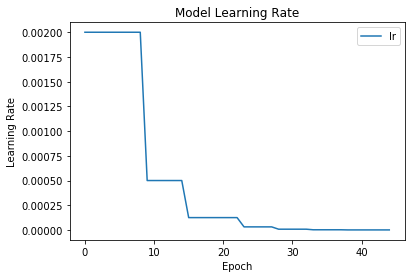

In [17]:
history_df[['lr']].plot()
plt.title('Model Learning Rate')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.show()

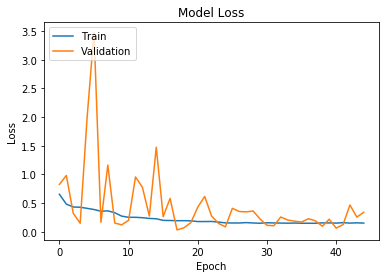

In [18]:
history_df[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

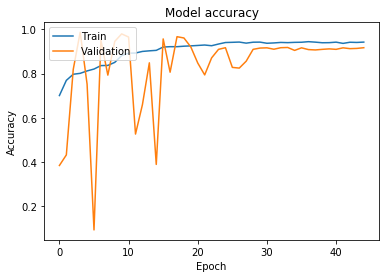

In [19]:
history_df[['accuracy', 'val_accuracy']].plot()
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

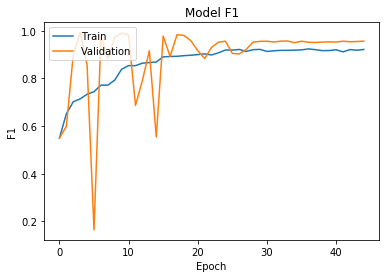

In [20]:
history_df[['f1_m', 'val_f1_m']].plot()
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

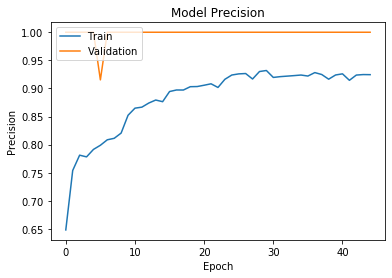

In [21]:
history_df[['precision_m', 'val_precision_m']].plot()
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

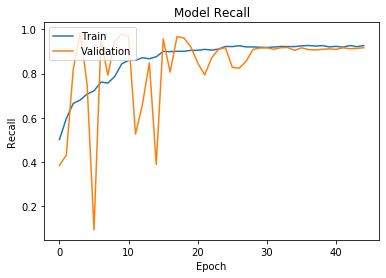

In [22]:
history_df[['recall_m', 'val_recall_m']].plot()
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()